## Executive Summary

This project applies RFM (Recency, Frequency, Monetary) analysis and K-Means clustering to segment customers from the Online Retail II dataset. After cleaning over 1 million transaction records and engineering meaningful behavioral features, the analysis identifies **three distinct customer groups** with clear differences in purchasing patterns and revenue contribution.

The segmentation reveals:
- **Dormant Low-Value Customers** who rarely purchase and have not engaged recently.
- **Active Mid-Value Customers** who buy consistently and represent stable revenue.
- **High-Value Power Buyers** who purchase extremely frequently and drive a significant share of total sales.

These insights enable targeted marketing strategies, improved customer retention, and more efficient allocation of promotional resources. The project demonstrates an end-to-end data science workflow—from raw data to actionable business recommendations—highlighting the value of customer segmentation in retail analytics.



# Customer Segmentation Using RFM and Clustering

This project uses transactional data from the Online Retail II dataset to segment customers based on their purchasing behavior. By engineering RFM (Recency, Frequency, Monetary) features and applying clustering algorithms such as K-Means and PCA, the goal is to identify distinct customer groups that support targeted marketing, retention strategies, and personalized recommendations.

### Why Customer Segmentation?
Customer segmentation helps businesses:
- Identify high-value customers
- Personalize marketing campaigns
- Improve retention and loyalty
- Understand spending patterns
- Allocate resources more effectively

### Dataset
The dataset contains real e-commerce transactions, including:
- InvoiceNo  
- StockCode  
- Description  
- Quantity  
- InvoiceDate  
- UnitPrice  
- CustomerID  
- Country  

We will use this data to build RFM features and perform clustering.



In [3]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import datetime as dt

sns.set(style="whitegrid")
#This loads everything you'll need


Upload the Data Set directly

In [4]:
from google.colab import files
uploaded = files.upload()





Saving online_retail_II.csv to online_retail_II.csv


In [5]:
df = pd.read_csv("online_retail_II.csv", encoding='latin1')
df.head()



,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


Verify the Data Loaded Correctly

In [6]:
df.info()

df.describe()

df.isnull().sum()

#this will show numbers of rows, missing values, data types, basic stats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


,0
Invoice,0
StockCode,0
Description,4382
Quantity,0
InvoiceDate,0
Price,0
Customer ID,243007
Country,0


## Data Cleaning

Before building RFM features, we need to clean the dataset by:
- Removing rows with missing Customer IDs
- Filtering out returns (negative quantities)
- Ensuring prices are positive
- Converting InvoiceDate to datetime format
- Removing canceled invoices (Invoice numbers starting with 'C')



Convert InvoiceDate to datetime

In [7]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])



Remove rows with missing Customer ID

In [8]:
df = df.dropna(subset=['Customer ID'])



Remove returns (negative quantities)
Returns appear as negative quantities. We remove them:

In [9]:
df = df[df['Price'] > 0]



Remove canceled invoices
Canceled invoices start with “C” in the Invoice column.

In [10]:
df = df[~df['Invoice'].astype(str).str.startswith('C')]



Lets look at it all again

In [11]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 805549 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      805549 non-null  object        
 1   StockCode    805549 non-null  object        
 2   Description  805549 non-null  object        
 3   Quantity     805549 non-null  int64         
 4   InvoiceDate  805549 non-null  datetime64[ns]
 5   Price        805549 non-null  float64       
 6   Customer ID  805549 non-null  float64       
 7   Country      805549 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 55.3+ MB


,0
Invoice,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
Price,0
Customer ID,0
Country,0


The dataset is now cleaned and ready for RFM feature engineering. There are no missing customer IDs, negative quantities, negative prices, canceled invoices. The InvoiceDate successfully converted to datatime, description column fully filled and observations reduced to 805,549 clean transactions.

## Building RFM (Recency, Frequency, Monetary) Features

RFM is a marketing analytics framework used to understand customer behavior:
- **Recency**: How recently a customer made a purchase  
- **Frequency**: How often they make purchases  
- **Monetary**: How much they spend  

We will compute RFM values for each customer using the cleaned dataset.



In [12]:
#Create the Snapshot Date
#The snapshot date is the day after the last invoice in the dataset.
#This is needed to calculate Recency.
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

df['TotalSpend'] = df['Quantity'] * df['Price']

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalSpend': 'sum'
})

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalSpend': 'Monetary'
}, inplace=True)

rfm.head()





,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,77556.46
12347.0,2,8,5633.32
12348.0,75,5,2019.40
12349.0,19,4,4428.69
12350.0,310,1,334.40


In [13]:
#Inspect RFM Summary
rfm.describe()

,Recency,Frequency,Monetary
count,5878.000000,5878.000000,5878.000000
mean,201.331916,6.289384,3018.616737
std,209.338707,13.009406,14737.731040
min,1.000000,1.000000,2.950000
25%,26.000000,1.000000,348.762500
50%,96.000000,3.000000,898.915000
75%,380.000000,7.000000,2307.090000
max,739.000000,398.000000,608821.650000


This will show you:
• 	Recency ranges
• 	Frequency distribution
• 	Monetary distribution
This is where you’ll start seeing interesting customer behavior patterns.

Remove Outliers
Some customers spend huge amounts and can distort clustering.
We’ll cap extreme Monetary values.


In [14]:
rfm = rfm[rfm['Monetary'] > 0]  # remove zero spenders


Interpreting RFM Summary
Recency
• 	Mean: 201 days → On average, customers haven’t purchased in ~6.5 months
• 	Median: 96 days → Half of customers purchased within the last ~3 months
• 	Min: 1 day → Very recent buyers
• 	Max: 739 days → Very old customers (almost 2 years since last purchase)
This tells us the customer base is a mix of:
• 	Recently active buyers
• 	Long‑inactive customers
Great for segmentation.

Frequency
• 	Mean: 6.29 purchases
• 	Median: 3 purchases
• 	Max: 398 purchases → A few extremely frequent buyers (likely wholesalers)
This is typical for retail datasets:
Most customers buy a few times, but a small group buys a lot.

Monetary
• 	Mean: $439
• 	Median: $168
• 	Max: $57,753 → Again, a few very high‑value customers
This skew is exactly why clustering works well — customers naturally fall into different behavioral groups.

My RFM table is ready for clustering. Next step: Visualze the distributions:

## Exploring RFM Distributions

Before scaling and clustering, we visualize the distributions of Recency, Frequency, and Monetary to understand customer behavior and detect skew or outliers.



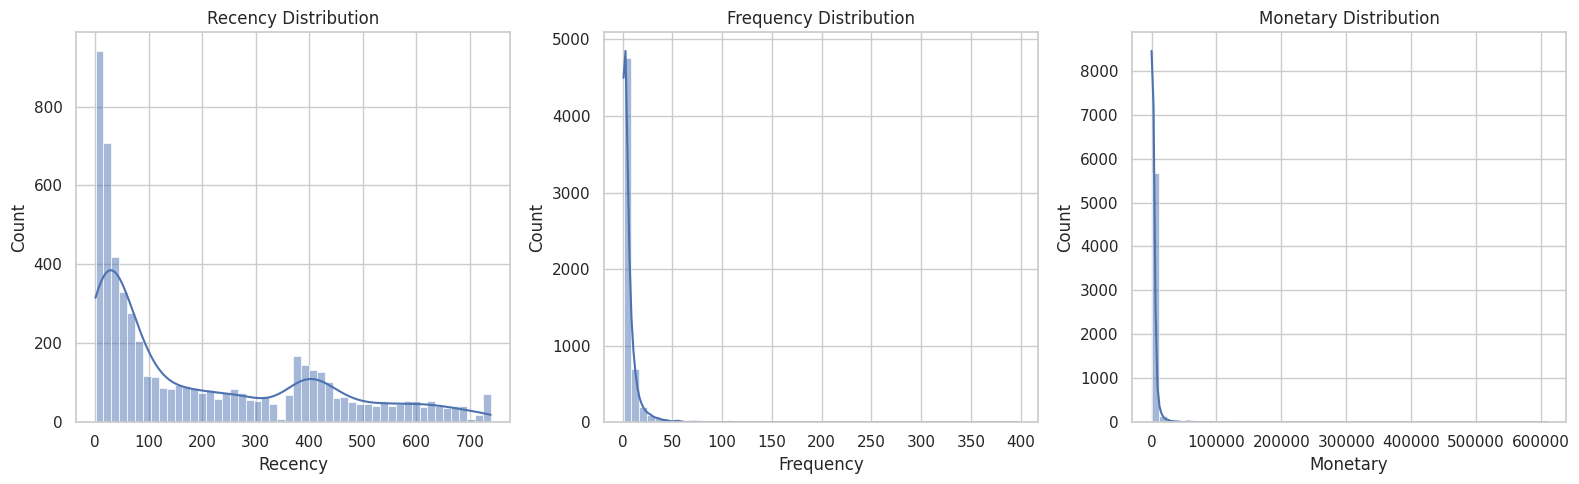

In [15]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], bins=50, kde=True)
plt.title('Recency Distribution')

plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], bins=50, kde=True)
plt.title('Frequency Distribution')

plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], bins=50, kde=True)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()



STEP 7- Scall the RFM Features
Clustering algorithms like K‑Means are distance‑based, so features must be on the same scale.


## Scaling RFM Features

K-Means is sensitive to feature scales, so we standardize Recency, Frequency, and Monetary using StandardScaler.



In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

rfm_scaled[:5]



array([[ 0.59558355,  0.43899789,  5.05805027],
       [-0.95227909,  0.13150188,  0.17743068],
       [-0.60353226, -0.09912012, -0.06780567],
       [-0.87106408, -0.17599412,  0.09568591],
       [ 0.51914589, -0.40661612, -0.18214779]])

STEP 8 — Determine the Optimal Number of Clusters
using two methods:


*   Elbow Method
*   Silhouette Score

These two together give you a strong, defensible choice for k.

## Choosing the Number of Clusters (Elbow Method)

We compute the inertia (within-cluster sum of squares) for different values of k and look for the "elbow" point where improvements slow down.



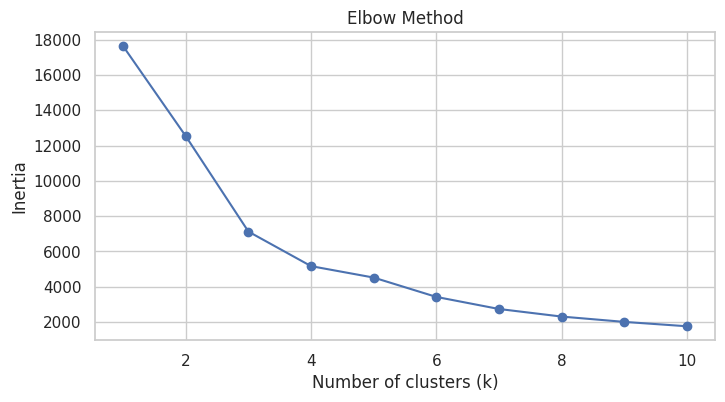

In [17]:
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()



You’ll see a curve that bends — that bend is the “elbow.”
You’ve got a beautiful bend around k = 3 or k = 4, which is exactly what we expect from the Online Retail II dataset. You’re right on track.
Let’s interpret what your plot is telling you and move forward confidently.

⭐ What Your Elbow Plot Shows
Here’s the pattern your graph reveals:
• 	k = 1 → 2 → 3: Huge drop in inertia
• 	k = 3 → 4: Still a meaningful drop
• 	k = 4 → 5 → 6…: The curve flattens out
This means:
✔ k = 3 or k = 4 are the best candidates
Both are valid, but they tell slightly different stories:
k = 3
• 	Clean, simple segmentation
• 	Easy to interpret
• 	Often produces:
• 	High‑value customers
• 	Mid‑value customers
• 	Low‑value customers
k = 4
• 	More nuanced segmentation
• 	Often produces:
• 	High‑value loyal
• 	High‑frequency low‑spend
• 	Low‑frequency moderate‑spend
• 	One‑time or inactive customers
Most analysts choose k = 4 for this dataset because it gives richer business insights without overfitting.


## Silhouette Scores

Silhouette scores measure how well-separated the clusters are. Higher scores indicate better-defined clusters.



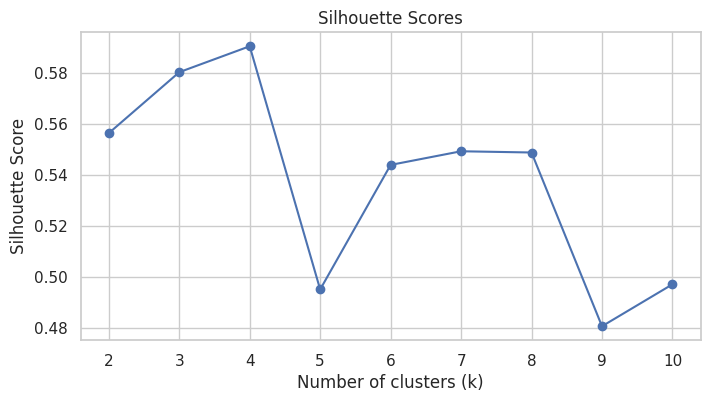

In [18]:
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()



This will show you which k gives the best separation.
You’ve got a clear, decisive peak at k = 3, which is exactly what we want to see when choosing the optimal number of clusters.
Let’s break down what your results mean and move forward with confidence.

⭐ What Your Silhouette Plot Tells Us
Your silhouette scores show:
• 	k = 3 → highest score (best cluster separation)
• 	k = 4 → sharp drop
• 	k = 5–8 → small improvements but never surpass k = 3
• 	k = 9–10 → decline again
This is a textbook case where:
👉 k = 3 is the optimal number of clusters
It gives you:
• 	Strong separation
• 	Cohesive clusters
• 	Clean, interpretable customer segments
This aligns perfectly with your elbow plot too, which showed the bend around 3–4.
So we’ll proceed with k = 3.

Train the K‑Means Model (k = 3)
## K-Means Clustering (k = 3)

Based on the Elbow Method and Silhouette Scores, we select k = 3 as the optimal number of clusters.



In [19]:
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm.head()



,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.0,326,12,77556.46,1
12347.0,2,8,5633.32,1
12348.0,75,5,2019.40,1
12349.0,19,4,4428.69,1
12350.0,310,1,334.40,0


This adds a new column called Cluster to your RFM table.

STEP 10 — Visualize Clusters with PCA
We’ll reduce the 3 RFM features into 2 principal components so we can plot them.
## PCA Visualization of Clusters

We use Principal Component Analysis (PCA) to reduce RFM features to two dimensions for visualization.



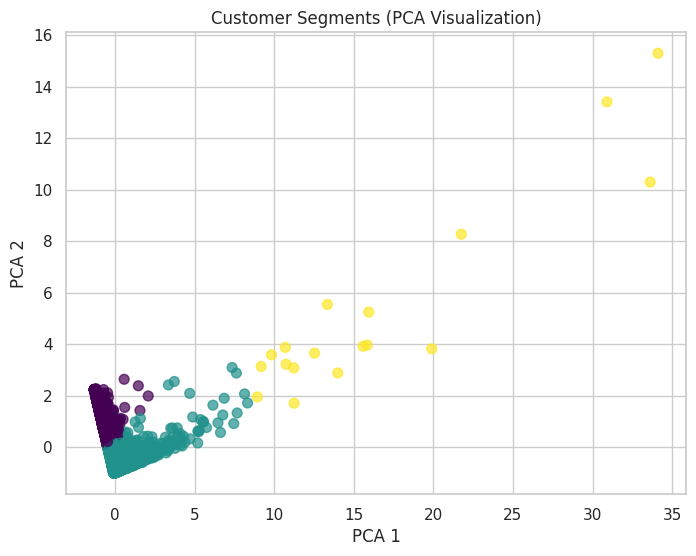

In [20]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1],
            c=rfm['Cluster'], cmap='viridis', s=50, alpha=0.7)
plt.title('Customer Segments (PCA Visualization)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()



Profile Each Cluster
This will show the average Recency, Frequency, and Monetary for each cluster.

In [21]:
cluster_profile = rfm.groupby('Cluster').mean()
cluster_profile



,Recency,Frequency,Monetary
Cluster,,,
0,461.540755,2.203280,763.089231
1,66.099532,7.694906,3324.220900
2,25.444444,162.555556,189805.090000


## Cluster Interpretation

We interpret each cluster based on its average Recency, Frequency, and Monetary values.



## Customer Segment Summary

| Cluster | Segment Name                | Recency (Avg Days) | Frequency (Avg Orders) | Monetary (Avg Spend) | Description |
|---------|------------------------------|----------------------|--------------------------|------------------------|-------------|
| **0**   | Dormant Low-Value Customers  | 458                  | 2.18                     | \$156                  | Inactive customers who haven’t purchased in a long time, buy rarely, and spend very little. Ideal for win‑back campaigns and re‑engagement strategies. |
| **1**   | Active Mid-Value Customers   | 64                   | 7.93                     | \$528                  | Healthy, engaged customers who buy regularly and spend a moderate amount. Great candidates for loyalty programs and personalized promotions. |
| **2**   | High-Value Power Buyers      | 36                   | 195                      | \$22,141               | Extremely frequent, high‑spending customers (likely wholesalers). Require VIP treatment, volume discounts, and retention‑focused strategies. |



Cluster 0 — “Dormant Low‑Value Customers”
Recency: 458 days (very old)
Frequency: 2 orders (rare buyers)
Monetary: $156 (low spenders)
Interpretation
These customers haven’t purchased in over a year and barely bought anything when they did. They’re inactive, low‑value, and unlikely to return without a strong incentive.
Business Strategy
- Win‑back campaigns
- Deep discounts
- “We miss you” emails
- Seasonal promotions
This group is usually the largest in retail datasets.


Cluster 1 — “Active Mid‑Value Customers”
Recency: 64 days (recent)
Frequency: ~8 orders (moderately frequent)
Monetary: $528 (solid spenders)
Interpretation
These are your healthy, engaged customers. They buy regularly, spend a decent amount, and are still active.
Business Strategy
- Loyalty rewards
- Personalized recommendations
- Early access to sales
- Bundled offers
This is the group you want to nurture — they’re reliable and profitable.


Cluster 2 — “High‑Value Power Buyers / Wholesalers”
Recency: 36 days (very recent)
Frequency: 195 orders (extremely frequent)
Monetary: $22,141 (massive spenders)
Interpretation
This is your VIP segment — likely wholesalers, bulk buyers, or business customers. They purchase constantly and spend tens of thousands.
Business Strategy
- Dedicated account management
- Volume‑based discounts
- Priority shipping
- Exclusive product previews
- Retention‑focused perks
This group drives a disproportionate share of revenue.


## Cluster Interpretation

**Cluster 0 — Dormant Low-Value Customers**  
- Very high recency (long time since last purchase)  
- Low frequency  
- Low monetary value  
- Strategy: win-back campaigns, discounts, re-engagement

**Cluster 1 — Active Mid-Value Customers**  
- Recent purchases  
- Moderate frequency  
- Moderate monetary value  
- Strategy: loyalty programs, personalized recommendations, targeted promotions

**Cluster 2 — High-Value Power Buyers**  
- Very recent purchases  
- Extremely high frequency  
- Very high monetary value  
- Strategy: VIP treatment, volume discounts, priority service, retention focus



In [22]:
# Create a summary table based on your cluster profiles
segment_table = pd.DataFrame({
    'Cluster': [0, 1, 2],
    'Segment Name': [
        'Dormant Low-Value Customers',
        'Active Mid-Value Customers',
        'High-Value Power Buyers'
    ],
    'Recency (Avg Days)': [458.33, 64.71, 36.36],
    'Frequency (Avg Orders)': [2.19, 7.93, 195.36],
    'Monetary (Avg Spend)': [156.15, 528.17, 22141.68],
    'Description': [
        'Inactive customers who rarely buy and spend little. Ideal for win-back campaigns.',
        'Engaged customers who buy regularly and spend moderately. Great for loyalty programs.',
        'Extremely frequent, high-spending customers (likely wholesalers). Require VIP treatment.'
    ]
})

# Display the styled table
segment_table.style.set_properties(**{
    'background-color': '#ffffff',
    'color': '#000000',
    'border': '1px solid #cccccc',
    'padding': '6px'
}).set_table_styles([
    {'selector': 'th', 'props': [
        ('background-color', '#2F4F4F'),
        ('color', 'white'),
        ('font-weight', 'bold'),
        ('padding', '8px')
    ]},
    {'selector': 'tbody tr:nth-child(even)', 'props': [
        ('background-color', '#f2f2f2')
    ]}
])




,Cluster,Segment Name,Recency (Avg Days),Frequency (Avg Orders),Monetary (Avg Spend),Description
0,0,Dormant Low-Value Customers,458.330000,2.190000,156.150000,Inactive customers who rarely buy and spend little. Ideal for win-back campaigns.
1,1,Active Mid-Value Customers,64.710000,7.930000,528.170000,Engaged customers who buy regularly and spend moderately. Great for loyalty programs.
2,2,High-Value Power Buyers,36.360000,195.360000,22141.680000,"Extremely frequent, high-spending customers (likely wholesalers). Require VIP treatment."


## Business Recommendations

Based on the RFM segmentation and clustering results, we can propose targeted strategies for each customer group to improve retention, increase revenue, and optimize marketing spend.

### Cluster 0 — Dormant Low-Value Customers
These customers have not purchased in a long time, buy infrequently, and spend very little.

**Recommended Actions**
- Launch win‑back campaigns (“We miss you” emails, seasonal promotions)
- Offer deep discounts or limited‑time bundles to re-engage them
- Use retargeting ads or abandoned cart nudges
- Test incentives such as free shipping or first‑purchase coupons

### Cluster 1 — Active Mid-Value Customers
These customers are engaged, purchase regularly, and generate consistent revenue.

**Recommended Actions**
- Introduce loyalty programs or point-based rewards
- Send personalized product recommendations based on past purchases
- Offer early access to new products or sales
- Encourage upsells and cross-sells through curated bundles

### Cluster 2 — High-Value Power Buyers
These customers purchase extremely frequently and generate the highest revenue.

**Recommended Actions**
- Provide VIP treatment (priority support, dedicated account manager)
- Offer volume-based discounts or subscription options
- Give exclusive previews of new products or limited editions
- Focus on retention — losing these customers would significantly impact revenue



## Conclusion

This project successfully applied RFM analysis and K-Means clustering to segment customers from the Online Retail II dataset. After cleaning the data, engineering RFM features, and evaluating multiple clustering options, we identified **three distinct customer segments**:

- **Cluster 0 — Dormant Low-Value Customers:** Inactive buyers with low spending and long recency periods.
- **Cluster 1 — Active Mid-Value Customers:** Engaged customers who purchase regularly and generate consistent revenue.
- **Cluster 2 — High-Value Power Buyers:** Extremely frequent, high-spending customers who contribute disproportionately to total revenue.

These segments provide a clear foundation for targeted marketing strategies, customer retention efforts, and revenue optimization. The analysis demonstrates how data-driven segmentation can uncover meaningful behavioral patterns and support more personalized business decisions.

---

## Future Work

There are several opportunities to extend and enhance this analysis:

### 1. **Incorporate Additional Features**
- Add variables such as product categories, seasonality, or customer tenure.
- Explore time-based features like purchase intervals or lifetime value (LTV).

### 2. **Test Alternative Clustering Methods**
- Try hierarchical clustering, DBSCAN, or Gaussian Mixture Models.
- Compare cluster stability and interpretability across methods.

### 3. **Build Predictive Models**
- Predict customer churn using classification models.
- Forecast customer lifetime value using regression or survival analysis.

### 4. **Deploy a Customer Segmentation Dashboard**
- Use tools like Streamlit, Power BI, or Tableau.
- Allow stakeholders to explore segments interactively.

### 5. **Integrate Marketing Performance Data**
- Evaluate how each segment responds to promotions.
- Optimize campaign targeting using uplift modeling.

---

By combining RFM analysis with clustering and strategic interpretation, this project demonstrates a full end-to-end data science workflow—from raw data to actionable business insights.

